## POS tagging using modified Viterbi

### Data Preparation

In [67]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [68]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [69]:
# Each sentence is a list of (word, pos) tuples
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [70]:
# Splitting into train and validation
random.seed(1234)
train_set, val_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(val_set))
print(train_set[:40])

3718
196
[[('The', 'DET'), ('service', 'NOUN'), ('--', '.'), ('which', 'DET'), ('*T*-2', 'X'), ('costs', 'VERB'), ('the', 'DET'), ('caller', 'NOUN'), ('from', 'ADP'), ('30', 'NUM'), ('cents', 'NOUN'), ('to', 'PRT'), ('$', '.'), ('25', 'NUM'), ('*U*', 'X'), ('a', 'DET'), ('minute', 'NOUN'), ('--', '.'), ('currently', 'ADV'), ('is', 'VERB'), ('dominated', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('celebrity', 'NOUN'), ('chatter', 'NOUN'), (',', '.'), ('horoscopes', 'NOUN'), ('and', 'CONJ'), ('romance', 'NOUN'), ('lines', 'NOUN'), ('.', '.')], [('But', 'CONJ'), ('we', 'PRON'), ('are', 'VERB'), ('not', 'ADV'), ('going', 'VERB'), ('back', 'ADV'), ('to', 'PRT'), ('1970', 'NUM'), ('.', '.'), ("''", '.')], [('``', '.'), ('*', 'X'), ('Consider', 'VERB'), ('Jim', 'NOUN'), ('Courter', 'NOUN'), ('.', '.'), ("''", '.')], [('The', 'DET'), ('sale', 'NOUN'), ('represents', 'VERB'), ('10.2', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('Meridian', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('outstanding', 'ADJ

In [71]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95927

In [72]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'service',
 '--',
 'which',
 '*T*-2',
 'costs',
 'the',
 'caller',
 'from',
 '30']

In [73]:
# vocabulary
V = set(tokens)
print(len(V))

12121


In [74]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [75]:
print(T)

{'ADJ', 'NUM', 'ADP', '.', 'NOUN', 'PRT', 'CONJ', 'PRON', 'ADV', 'DET', 'X', 'VERB'}


##### POS Tagging Algorithm - HMM


We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

#### Emission Probabilities

In [76]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [77]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [78]:
# example

# There
print("\n", "There")
print(word_given_tag('There', 'VERB'))
print(word_given_tag('There', 'NOUN'))
print(word_given_tag('There', 'DET'), "\n")


 There
(0, 12933)
(0, 27528)
(29, 8322) 



#### Transition Probabilities

In [79]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [80]:
# examples
print(t2_given_t1(t2='NOUN', t1='VERB'))
print(t2_given_t1('VERB', 'DET'))
print(t2_given_t1('DET', 'VERB'))
print(t2_given_t1('CONJ', 'PRON'))
print(t2_given_t1('X', 'CONJ'))



(1439, 12933)
(330, 8322)
(1734, 12933)
(11, 2585)
(19, 2154)


In [81]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [82]:
tags_matrix

array([[6.64593205e-02, 2.01342274e-02, 7.77541324e-02, 6.49860874e-02,
        6.99950874e-01, 1.08037321e-02, 1.75151415e-02, 6.54771633e-04,
        4.58340161e-03, 4.09232266e-03, 2.12800782e-02, 1.17858900e-02],
       [3.38781588e-02, 1.89004451e-01, 3.41753326e-02, 1.13818720e-01,
        3.52451712e-01, 2.67459136e-02, 1.30757801e-02, 1.78306096e-03,
        2.97176815e-03, 2.97176815e-03, 2.11292714e-01, 1.78306084e-02],
       [1.05941229e-01, 6.17546849e-02, 1.69293024e-02, 3.97146493e-02,
        3.23892683e-01, 1.49063033e-03, 1.06473593e-03, 6.84625208e-02,
        1.34156728e-02, 3.24212104e-01, 3.47103924e-02, 8.41141399e-03],
       [4.45939898e-02, 8.07536989e-02, 9.11619589e-02, 9.24181268e-02,
        2.21175417e-01, 2.33288459e-03, 5.82323894e-02, 6.53207749e-02,
        5.24001792e-02, 1.74338266e-01, 2.75459848e-02, 8.96366090e-02],
       [1.20604476e-02, 9.26329568e-03, 1.76547512e-01, 2.40446091e-01,
        2.64094740e-01, 4.39552441e-02, 4.24658544e-02, 4.57

In [83]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [84]:
tags_df

,ADJ,NUM,ADP,.,NOUN,PRT,CONJ,PRON,ADV,DET,X,VERB
ADJ,0.066459,0.020134,0.077754,0.064986,0.699951,0.010804,0.017515,0.000655,0.004583,0.004092,0.021280,0.011786
NUM,0.033878,0.189004,0.034175,0.113819,0.352452,0.026746,0.013076,0.001783,0.002972,0.002972,0.211293,0.017831
ADP,0.105941,0.061755,0.016929,0.039715,0.323893,0.001491,0.001065,0.068463,0.013416,0.324212,0.034710,0.008411
.,0.044594,0.080754,0.091162,0.092418,0.221175,0.002333,0.058232,0.065321,0.052400,0.174338,0.027546,0.089637
NOUN,0.012060,0.009263,0.176548,0.240446,0.264095,0.043955,0.042466,0.004577,0.017183,0.013368,0.029134,0.146905
PRT,0.085065,0.056818,0.020455,0.044481,0.243831,0.001948,0.001948,0.018182,0.009416,0.103247,0.013636,0.400974
CONJ,0.117920,0.041318,0.053853,0.035747,0.350046,0.004643,0.000464,0.058496,0.054318,0.118384,0.008821,0.155989
PRON,0.073888,0.007350,0.022824,0.039845,0.208124,0.012766,0.004255,0.007350,0.034429,0.009284,0.093617,0.486267
ADV,0.132025,0.031593,0.118723,0.137014,0.030595,0.013302,0.006984,0.014965,0.077486,0.069172,0.022281,0.345860
DET,0.204398,0.021990,0.009012,0.018145,0.638789,0.000240,0.000481,0.003605,0.012617,0.005287,0.045782,0.039654


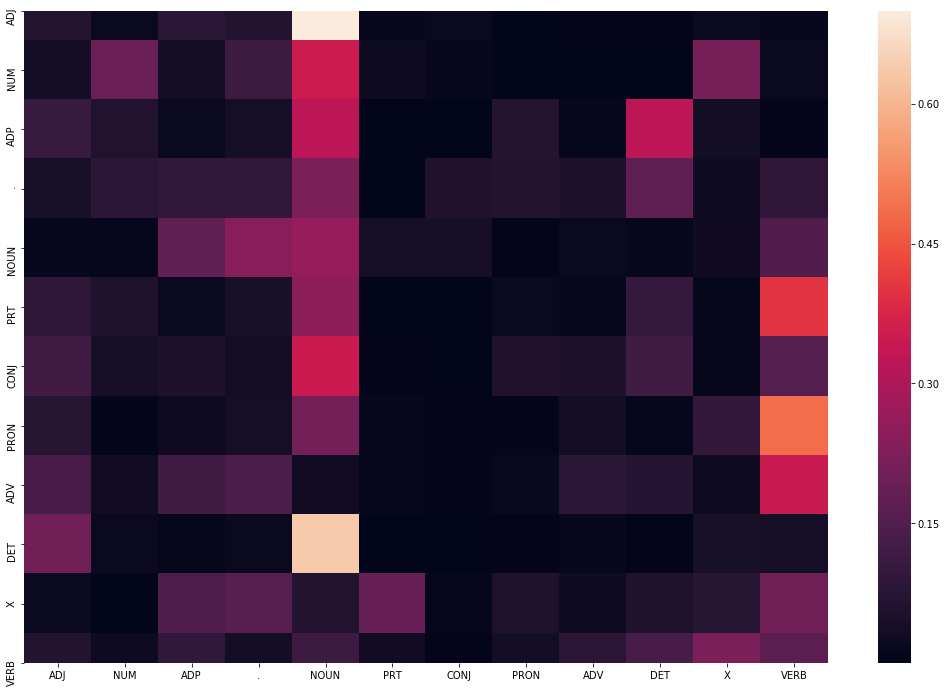

In [85]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


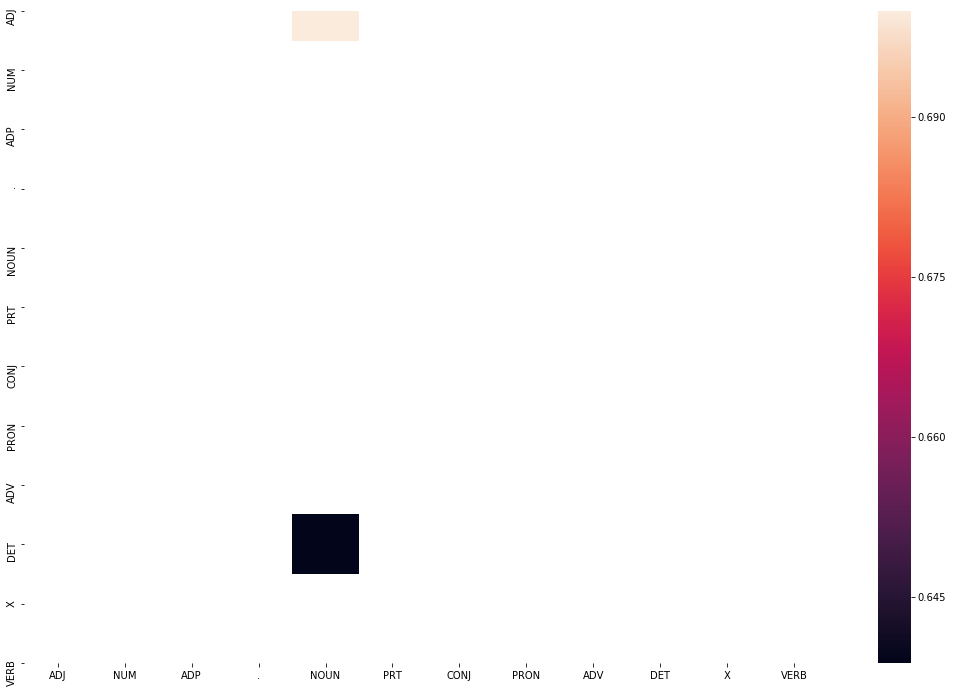

In [86]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [87]:
len(train_tagged_words)

95927

In [88]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p) 
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


#### Evaluating on Validation Set

In [89]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(val_set)) for x in range(5)]

# list of sents
test_run = [val_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('In', 'ADP'),
  ('a', 'DET'),
  ('well-known', 'ADJ'),
  ('detective-story', 'NOUN'),
  ('involving', 'VERB'),
  ('church', 'NOUN'),
  ('bells', 'NOUN'),
  (',', '.'),
  ('English', 'ADJ'),
  ('novelist', 'NOUN'),
  ('Dorothy', 'NOUN'),
  ('L.', 'NOUN'),
  ('Sayers', 'NOUN'),
  ('described', 'VERB'),
  ('ringing', 'VERB'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('``', '.'),
  ('passion', 'NOUN'),
  ('-LCB-', '.'),
  ('that', 'DET'),
  ('-RCB-', '.'),
  ('*T*-1', 'X'),
  ('finds', 'VERB'),
  ('its', 'PRON'),
  ('satisfaction', 'NOUN'),
  ('in', 'ADP'),
  ('mathematical', 'ADJ'),
  ('completeness', 'NOUN'),
  ('and', 'CONJ'),
  ('mechanical', 'ADJ'),
  ('perfection', 'NOUN'),
  ('.', '.'),
  ("''", '.')],
 [('``', '.'),
  ('It', 'PRON'),
  ('is', 'VERB'),
  ('the', 'DET'),
  ('very', 'ADJ'),
  ('building', 'NOUN'),
  ('of', 'ADP'),
  ('it', 'PRON'),
  ('*ICH*-4', 'X'),
  ('that', 'DET'),
  ('*T*-2', 'X'),
  ('is', 'VERB'),
  ('important', 'ADJ'),
  (',', '.'),
  ('not', 'ADV'),
  ('how', 

In [90]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [91]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  36.24675250053406
[('In', 'ADP'), ('a', 'DET'), ('well-known', 'ADJ'), ('detective-story', 'ADJ'), ('involving', 'VERB'), ('church', 'NOUN'), ('bells', 'NOUN'), (',', '.'), ('English', 'NOUN'), ('novelist', 'ADJ'), ('Dorothy', 'NOUN'), ('L.', 'NOUN'), ('Sayers', 'NOUN'), ('described', 'VERB'), ('ringing', 'VERB'), ('as', 'ADP'), ('a', 'DET'), ('``', '.'), ('passion', 'NOUN'), ('-LCB-', '.'), ('that', 'DET'), ('-RCB-', '.'), ('*T*-1', 'X'), ('finds', 'ADJ'), ('its', 'PRON'), ('satisfaction', 'ADJ'), ('in', 'ADP'), ('mathematical', 'ADJ'), ('completeness', 'ADJ'), ('and', 'CONJ'), ('mechanical', 'ADJ'), ('perfection', 'ADJ'), ('.', '.'), ("''", '.'), ('``', '.'), ('It', 'PRON'), ('is', 'VERB'), ('the', 'DET'), ('very', 'ADV'), ('building', 'VERB'), ('of', 'ADP'), ('it', 'PRON'), ('*ICH*-4', 'X'), ('that', 'ADP'), ('*T*-2', 'X'), ('is', 'VERB'), ('important', 'ADJ'), (',', '.'), ('not', 'ADV'), ('how', 'ADV'), ('much', 'ADV'), ('of', 'ADP'), ('it', 'PRON'), ('*T*-3

In [92]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [93]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.8881118881118881

In [94]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [95]:
incorrect_tagged_cases

[[('well-known', 'ADJ'),
  (('detective-story', 'ADJ'), ('detective-story', 'NOUN'))],
 [(',', '.'), (('English', 'NOUN'), ('English', 'ADJ'))],
 [('English', 'ADJ'), (('novelist', 'ADJ'), ('novelist', 'NOUN'))],
 [('*T*-1', 'X'), (('finds', 'ADJ'), ('finds', 'VERB'))],
 [('its', 'PRON'), (('satisfaction', 'ADJ'), ('satisfaction', 'NOUN'))],
 [('mathematical', 'ADJ'),
  (('completeness', 'ADJ'), ('completeness', 'NOUN'))],
 [('mechanical', 'ADJ'), (('perfection', 'ADJ'), ('perfection', 'NOUN'))],
 [('the', 'DET'), (('very', 'ADV'), ('very', 'ADJ'))],
 [('very', 'ADJ'), (('building', 'VERB'), ('building', 'NOUN'))],
 [('*ICH*-4', 'X'), (('that', 'ADP'), ('that', 'DET'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('announced', 'VERB'), (('*-118', 'ADJ'), ('*-118', 'X'))],
 [('which', 'DET'), (('*T*-192', 'ADJ'), ('*T*-192', 'X'))],
 [('$', '.'), (('1,29

#### Testing on the test set

In [96]:
sentence_test = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [97]:
print(tagged_seq)
print(difference)

[('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### Solve the problem of unknown words

#### Method 1: Using Unigram Tagger to deal with Unknown Words

In [122]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(val_set)

0.9109286165508528

Hence in the UniGram tagger method for Unknown words we get an accuracy of 91%. Which is better than the vanilla viterbi model.

#### Method 2 : Rule-based (Regular Expression) Tagger to solve the Unknown words issue 

In [123]:
patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # All tenses of verb are tagged to 'VERB'
    (r'^-?[0-9]+(.[0-9]+)?$', 'X'),   # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determiners
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives  
    (r'.*ly$', 'ADV'),                  # adverbs
         (r'.*s$', 'NOUN'),                  # plural nouns  
         (r'.*', 'NOUN')                      # nouns (default)
        ]

In [124]:
re_tagger = nltk.RegexpTagger(patterns)

In [127]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)



0.9481996209728364

#### Evaluating tagging accuracy

##### Method 1 : Unigram Tagger Accuracy

In [129]:
unigram_tagger.evaluate(val_set)

0.9109286165508528

##### Method 2: Rule based- Regex Tagger Accuracy

In [131]:
lexicon_tagger.evaluate(val_set)

0.9481996209728364

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

We can observe that with Method 1 : Unigram Tagger we do not see much efficiency increase. However we see a drastic increase in the accuracy with the Rule-based tagger. 

In [137]:
print ('Accuracy of Plain Vanilla Viterbi =' , accuracy)
print ('Accuracy of Viterbi with Unigram Tagger =' , unigram_tagger.evaluate(val_set))
print ('Accuracy of Viterbi with Rule Based Tagger =' , lexicon_tagger.evaluate(val_set))

Accuracy of Plain Vanilla Viterbi = 0.8881118881118881
Accuracy of Viterbi with Unigram Tagger = 0.9109286165508528
Accuracy of Viterbi with Rule Based Tagger = 0.9481996209728364


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Following is the list of Word | Tag combinations which were tagged incorrectly and got modified by the Tagger

In [133]:
Recitified_Tags = incorrect_tagged_cases
Recitified_Tags

[[('well-known', 'ADJ'),
  (('detective-story', 'ADJ'), ('detective-story', 'NOUN'))],
 [(',', '.'), (('English', 'NOUN'), ('English', 'ADJ'))],
 [('English', 'ADJ'), (('novelist', 'ADJ'), ('novelist', 'NOUN'))],
 [('*T*-1', 'X'), (('finds', 'ADJ'), ('finds', 'VERB'))],
 [('its', 'PRON'), (('satisfaction', 'ADJ'), ('satisfaction', 'NOUN'))],
 [('mathematical', 'ADJ'),
  (('completeness', 'ADJ'), ('completeness', 'NOUN'))],
 [('mechanical', 'ADJ'), (('perfection', 'ADJ'), ('perfection', 'NOUN'))],
 [('the', 'DET'), (('very', 'ADV'), ('very', 'ADJ'))],
 [('very', 'ADJ'), (('building', 'VERB'), ('building', 'NOUN'))],
 [('*ICH*-4', 'X'), (('that', 'ADP'), ('that', 'DET'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('announced', 'VERB'), (('*-118', 'ADJ'), ('*-118', 'X'))],
 [('which', 'DET'), (('*T*-192', 'ADJ'), ('*T*-192', 'X'))],
 [('$', '.'), (('1,29